In [23]:
from dataclasses import dataclass
from typing import Callable, Protocol
import time

import trimesh
import pyrender
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
import torch
from torch import Tensor, from_numpy

from v_prism.mapping.bayesian_hilbert_map import BayesianHilbertMapWithFullCovarianceMatrixNoInv
from v_prism.mapping.v_prism import VPRISM
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_multiple_objects_w_surface
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid
from v_prism.utils.kernels import GaussianKernel, LaplacianKernel
from v_prism.utils.visualization import gen_image_of_trimesh_scene, gen_mesh_for_sdf_batch_3d, gen_heatmap
from v_prism.utils.visualization import gen_pointcloud_for_X_y, gen_pointcloud_for_hinge_points
from v_prism.data_loading.negative_sampling import negative_sample_rays_in_sphere_uniform_each_step_multiclass
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane_multiple_objects
from v_prism.utils.subsample import grid_subsample_different_res, grid_subsample

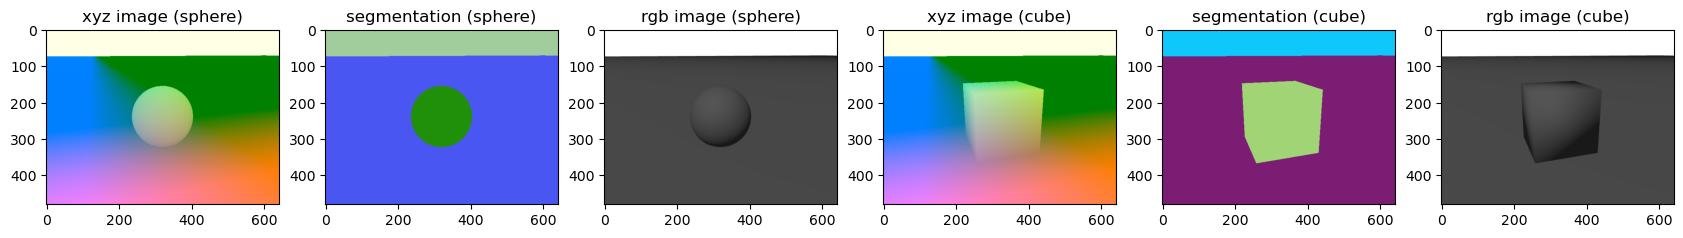

In [24]:
@dataclass
class Observation:
    xyz_image: Tensor
    segmentation: Tensor
    camera_pos: Tensor
    rgb_image: Tensor | None = None

    def __str__(self) -> str:
        return f'Observation(xyz_image={tuple(self.xyz_image.shape)}, segmentation={tuple(self.segmentation.shape)})'

@dataclass
class PrimitiveObject:
    mesh: trimesh.Trimesh
    occ_func: Callable[[Tensor], Tensor]

# with help from ChatGPT
def get_camera_pose_homogenous(camera_position, lookat_point, up_vector=[0, 1, 0]):
    forward = -(np.asarray(lookat_point, dtype=np.float64) - np.asarray(camera_position, dtype=np.float64))
    forward /= np.linalg.norm(forward)
    right = np.cross(np.array(up_vector), forward)
    right /= np.linalg.norm(right)
    up = np.cross(forward, right)
    up /= np.linalg.norm(up)
    homo_mat = np.eye(4)
    homo_mat[:3, :3] = np.stack([right, up, forward]).T
    homo_mat[:3, 3] = camera_position
    return homo_mat

# inspired by https://github.com/mvandermerwe/PointSDF/blob/master/data_generation/pyrender_generate_data.py
def generate_xyz_from_depth(depth, proj_matrix, cam_pose):
    """returns (3, H, W)"""
    kuf = proj_matrix[0][0]
    kvf = proj_matrix[1][1]
    height = depth.shape[0]
    width = depth.shape[1]
    norm_x = (np.arange(width).astype(np.float32)-(width*0.5)) / (width*0.5)
    norm_y = ((np.arange(height).astype(np.float32)-(height*0.5)) / (height*0.5)).reshape((-1, 1))
    world_x = norm_x * depth / kuf
    world_y = norm_y * depth / kvf
    world_z = -depth
    points = np.stack((world_x, -world_y, world_z, np.ones_like(world_x)), axis=-1).reshape((height, width, 4, 1)) # Negative on y because of image matrix layout.
    transformed_points: NDArray = (cam_pose @ points).reshape((height, width, 4))
    return transformed_points[:, :, :3]

def get_observation(
    objects: list[PrimitiveObject], 
    camera_pos: list[float], 
    lookat: list[float], 
    *, 
    table: trimesh.Trimesh = None,
) -> Observation:
    if table is None:
        table = create_table()
    scene = pyrender.Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))
    ids = {}
    table_node = scene.add(pyrender.Mesh.from_trimesh(table))
    ids[table_node] = 1
    for i, obj in enumerate(objects):
        obj_node = scene.add(pyrender.Mesh.from_trimesh(obj.mesh))
        ids[obj_node] = i+2
    cam = pyrender.camera.PerspectiveCamera(yfov=0.820305, aspectRatio=(4.0/3.0))
    cam_pose = get_camera_pose_homogenous(camera_pos, lookat)
    scene.add(
        cam, 
        pose=cam_pose
    )
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=1.0)
    light_node = scene.add(light, pose=get_camera_pose_homogenous(
        camera_position=[1, camera_pos[1] + 0.5, camera_pos[2]],
        lookat_point=lookat
    ))
    renderer = pyrender.OffscreenRenderer(viewport_width=640, viewport_height=480)
    seg, depth = renderer.render(scene, pyrender.RenderFlags.SEG, seg_node_map=ids)
    rgb = renderer.render(scene)[0]
    xyz = generate_xyz_from_depth(depth, cam.get_projection_matrix(), cam_pose)
    renderer.delete()
    return Observation(
        xyz_image=from_numpy(xyz),
        segmentation=from_numpy(seg[:, :, 0].copy()),
        camera_pos=torch.tensor(camera_pos),
        rgb_image=from_numpy(rgb.copy()),
    )
    

def create_sphere(pos: list[float], radius: float) -> PrimitiveObject:
    return PrimitiveObject(
        mesh=trimesh.primitives.Sphere(radius=radius, center=np.array(pos)),
        occ_func=lambda x: (torch.norm(x - torch.tensor(pos), dim=1) <= radius).to(torch.float64)
    )

def create_box(min: list[float], max: list[float]) -> PrimitiveObject:
    return PrimitiveObject(
        mesh=trimesh.creation.box(bounds=np.array([min, max])),
        occ_func=lambda x: (torch.prod(x >= torch.tensor(min), dim=-1) * torch.prod(x <= torch.tensor(max), dim=-1)).to(torch.float64)
    )

def create_table() -> trimesh.Trimesh:
    return create_box(min=[-100, -0.5, -100], max=[100, 0, 100]).mesh

def has_collision(objects: list[trimesh.Trimesh], *, add_table: bool = True) -> bool:
    if add_table:
        objects.append(create_table())
    raise NotImplementedError()

def create_seg_image(seg_mask: Tensor, *, color_map: dict | None = None) -> Tensor:
    H, W = seg_mask.shape
    image = np.zeros((H, W, 3))
    for id in np.unique(seg_mask):
        if color_map is not None and id in color_map:
            color = np.array(color_map[id])
        else:
            color = np.random.random(size=(3,))
        image[seg_mask == id] = color
    return image

# plot a couple images
fig, axs = plt.subplots(1, 6, figsize=(21, 3))

obs1 = get_observation(
    objects=[create_sphere(pos=[0, 0.5, 0], radius=0.5)],
    camera_pos=[3, 1.5, 1],
    lookat=[0, 0.5, 0],
)
axs[0].imshow(obs1.xyz_image * 0.4 + 0.5)
axs[0].set_title('xyz image (sphere)')
axs[1].imshow(create_seg_image(obs1.segmentation))
axs[1].set_title('segmentation (sphere)')
axs[2].imshow(obs1.rgb_image.numpy())
axs[2].set_title('rgb image (sphere)')


obs2 = get_observation(
    objects=[create_box(min=[-0.5, 0, -0.5], max=[0.5, 1, 0.5])],
    camera_pos=[3, 1.5, 1],
    lookat=[0, 0.5, 0],
)
axs[3].imshow(obs2.xyz_image.numpy() * 0.4 + 0.5)
axs[3].set_title('xyz image (cube)')
axs[4].imshow(create_seg_image(obs2.segmentation.numpy()))
axs[4].set_title('segmentation (cube)')
axs[5].imshow(obs2.rgb_image.numpy())
axs[5].set_title('rgb image (cube)')


plt.show()

In [25]:
@dataclass
class SceneExperimentData:
    objects: list[PrimitiveObject]
    obs: Observation
    points: Tensor
    segmentation: Tensor
    scene_center: Tensor
    hinge_points: Tensor
    dist_from_obj: Tensor

def get_scene_experiment_data(
    objects: list[PrimitiveObject],
    camera_pos: list[float],
    lookat: list[float], 
    resolution: float,
    dist_from_obj: float,
) -> SceneExperimentData:
    obs = get_observation(objects, camera_pos, lookat)
    H, W, D = obs.xyz_image.shape
    points = obs.xyz_image.reshape(H * W, D)
    segmentation = torch.relu(obs.segmentation.to(torch.int64).reshape(H * W) - 1)
    center = 0.5 * (torch.amin(points[segmentation == 1], dim=0) + torch.amax(points[segmentation == 1], dim=0))
    hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
        points=points,
        segmentation=segmentation,
        resolution=resolution,
        dist_from_obj=dist_from_obj,
        num_surface_points_per_obj=32
    )
    return SceneExperimentData(
        objects=objects,
        obs=obs,
        points=points,
        segmentation=segmentation,
        scene_center=center,
        hinge_points=hinge_points,
        dist_from_obj=dist_from_obj
    )


hingepoints: torch.Size([559, 3])
X: torch.Size([56278, 3])


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


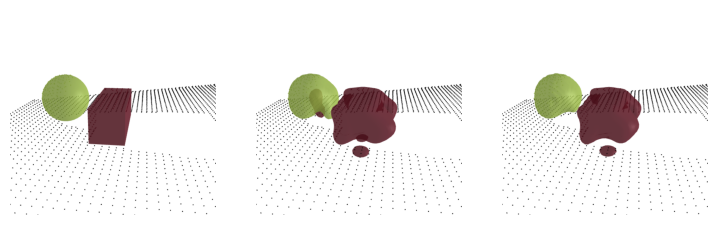

In [30]:
scene_objects = [
    create_box(min=[-0.35 , 0.0, -0.15], max=[0.35, 0.25, 0.1]),
    # create_box(min=(-0.15, 0, -0.5), max=[0.15, 0.3, -0.2]),
    create_sphere(pos=[-0.12, 0.2, 0.4], radius=0.2)
]
camera_pos = [0, 1, 2]
lookat = [0, 0.2, 0]
ray_step_size = 0.4
object_sphere_radius = 0.7
subsample_grid_size_unocc = 0.03
subsample_grid_size_occ = 0.015


scene_exp_data: SceneExperimentData = get_scene_experiment_data(
    objects=scene_objects, 
    camera_pos=camera_pos, 
    lookat=lookat,
    resolution=0.1,
    dist_from_obj=0.4,
)

print(f"hingepoints: {scene_exp_data.hinge_points.shape}")

num_objects = int(torch.amax(scene_exp_data.segmentation))
kernel = GaussianKernel(100)



scene_center = 0.5 * (
    torch.amax(scene_exp_data.points[scene_exp_data.segmentation > 0], dim=0) 
    + torch.amin(scene_exp_data.points[scene_exp_data.segmentation > 0], dim=0)
)
X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
    points=scene_exp_data.points, 
    mask=scene_exp_data.segmentation, 
    step_size=ray_step_size, 
    radius=object_sphere_radius, 
    camera_pos=torch.tensor(camera_pos),
)
X, y = add_negative_points_below_plane_multiple_objects(
    X, y, plane=[0, 1, 0, 0], center=scene_center, radius=0.9, k=20000
)

X, y = grid_subsample_different_res(
    X, 
    y, 
    subsample_grid_size_unocc=subsample_grid_size_unocc, 
    subsample_grid_size_occ=subsample_grid_size_occ,
)
print(f"X: {X.shape}")

# (4) fit maps
vprism_map = VPRISM(num_objects + 1, scene_exp_data.hinge_points, kernel, num_iterations=3)
vprism_map.sequential_update(X, y, 20000)
sigmoid_bhms = [(
    BayesianHilbertMapWithFullCovarianceMatrixNoInv(hinge_points=scene_exp_data.hinge_points, kernel=kernel, num_iterations=3)
) for i in range(num_objects)]
for i in range(num_objects):
    sigmoid_bhms[i].sequential_update(X, y == i+1, max_points_in_update=20000)


recon_meshes_soft = []
recon_meshes_sig = []
pointclouds = []
cmap = {}
for i in range(num_objects):
    random_color = torch.randint(0, 255, size=(4,))
    random_color[3] = 215
    cmap[i + 1] = random_color
    scene_objects[i].mesh.visual.vertex_colors = random_color
    
    iou_extent_lengths = [0.6, 0.4, 0.6]
    xlim = [scene_exp_data.scene_center[0] - iou_extent_lengths[0], scene_exp_data.scene_center[0] + iou_extent_lengths[0]]
    ylim = [scene_exp_data.scene_center[1] - iou_extent_lengths[1], scene_exp_data.scene_center[1] + iou_extent_lengths[1]]
    zlim = [scene_exp_data.scene_center[2] - iou_extent_lengths[2], scene_exp_data.scene_center[2] + iou_extent_lengths[2]]

    recon_mesh_sig_i = gen_mesh_for_sdf_batch_3d(sigmoid_bhms[i].predict, xlim=xlim, ylim=ylim, zlim=zlim, resolution=0.02)
    recon_mesh_soft_i = gen_mesh_for_sdf_batch_3d(lambda x: vprism_map.predict(x)[:, i+1], xlim=xlim, ylim=ylim, zlim=zlim, resolution=0.02)
    
    recon_mesh_sig_i.visual.vertex_colors = random_color
    recon_mesh_soft_i.visual.vertex_colors = random_color
    recon_meshes_sig.append(recon_mesh_sig_i)
    recon_meshes_soft.append(recon_mesh_soft_i)

    mask_i = scene_exp_data.segmentation == i+1
    random_color[3] = 255
    pointcloud_subsampled, _ = grid_subsample(scene_exp_data.points[mask_i], torch.zeros_like(scene_exp_data.points[mask_i][:, 0]), 0.05)
    pc = trimesh.PointCloud(pointcloud_subsampled)
    pc.visual.vertex_colors = random_color
    pointclouds.append(pc)

table_mask = scene_exp_data.obs.segmentation.reshape(-1) == 1
table_pointcloud_subsampled, _ = grid_subsample(scene_exp_data.points[table_mask], torch.zeros_like(scene_exp_data.points[table_mask][:, 0]), 0.05)
pointclouds.append(trimesh.PointCloud(table_pointcloud_subsampled))


view_params=[0, 1.8, -0.3, 2]
view_kwargs = {
    'theta': 0,
    'phi': 1.7,
    'pi': -0.3,
    'rho': 2,
    'lookat_position': scene_exp_data.scene_center,
    'rotate': False,
}

meshes = [obj.mesh for obj in scene_objects]
gt_img = gen_image_of_trimesh_scene(trimesh.Scene([*pointclouds, *meshes]), **view_kwargs)
sigmoid_img = gen_image_of_trimesh_scene(trimesh.Scene([*pointclouds, *recon_meshes_sig]), **view_kwargs)
softmax_img = gen_image_of_trimesh_scene(trimesh.Scene([*pointclouds, *recon_meshes_soft]), **view_kwargs)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(gt_img)
axs[0].set_axis_off()
axs[1].imshow(sigmoid_img)
axs[1].set_axis_off()
axs[2].imshow(softmax_img)
axs[2].set_axis_off()
plt.show()

